<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#os lobs
import os
import itertools
import shutil
from PIL import Image
# Data Handling libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
# DeepLearning Tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Activation , Flatten , BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load Training Data
train_data_dir = '/content/drive/MyDrive/DIP_Aug_dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [ ]:
#Load Testing Data
train_data_dir = '/content/drive/MyDrive/DIP_Aug_dataset/test'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

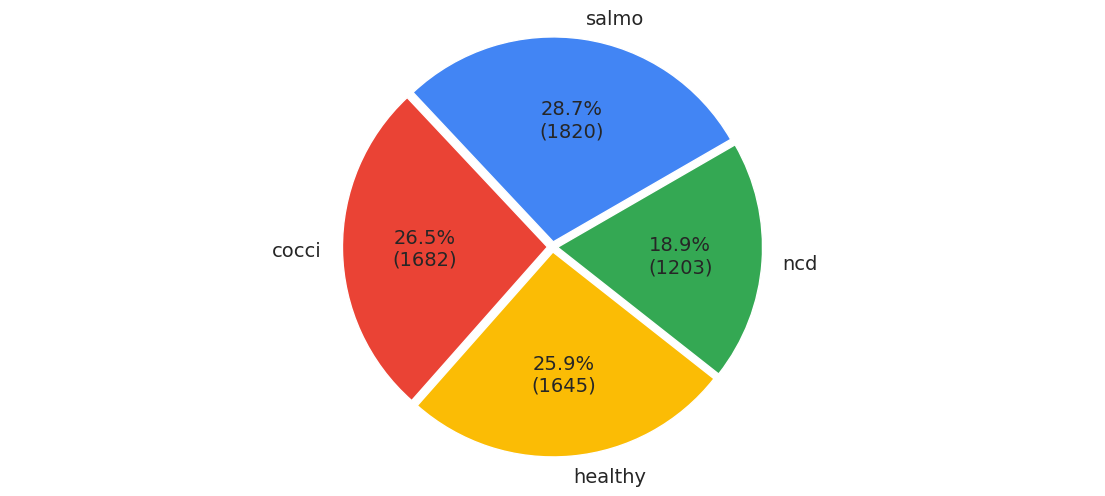

In [ ]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [ ]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
class_names = train_df['labels'].unique().tolist()
class_names

['cocci', 'healthy', 'ncd', 'salmo']

In [ ]:
# Augment and Preprocess Scans
batch_size =64
img_size = (240, 240)

tr_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = test_gen.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)
# batch_size = 32
# img_size = (240, 240)

# tr_gen = ImageDataGenerator()
# ts_gen = ImageDataGenerator()

# train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 6350 validated image filenames belonging to 4 classes.
Found 1590 validated image filenames belonging to 4 classes.


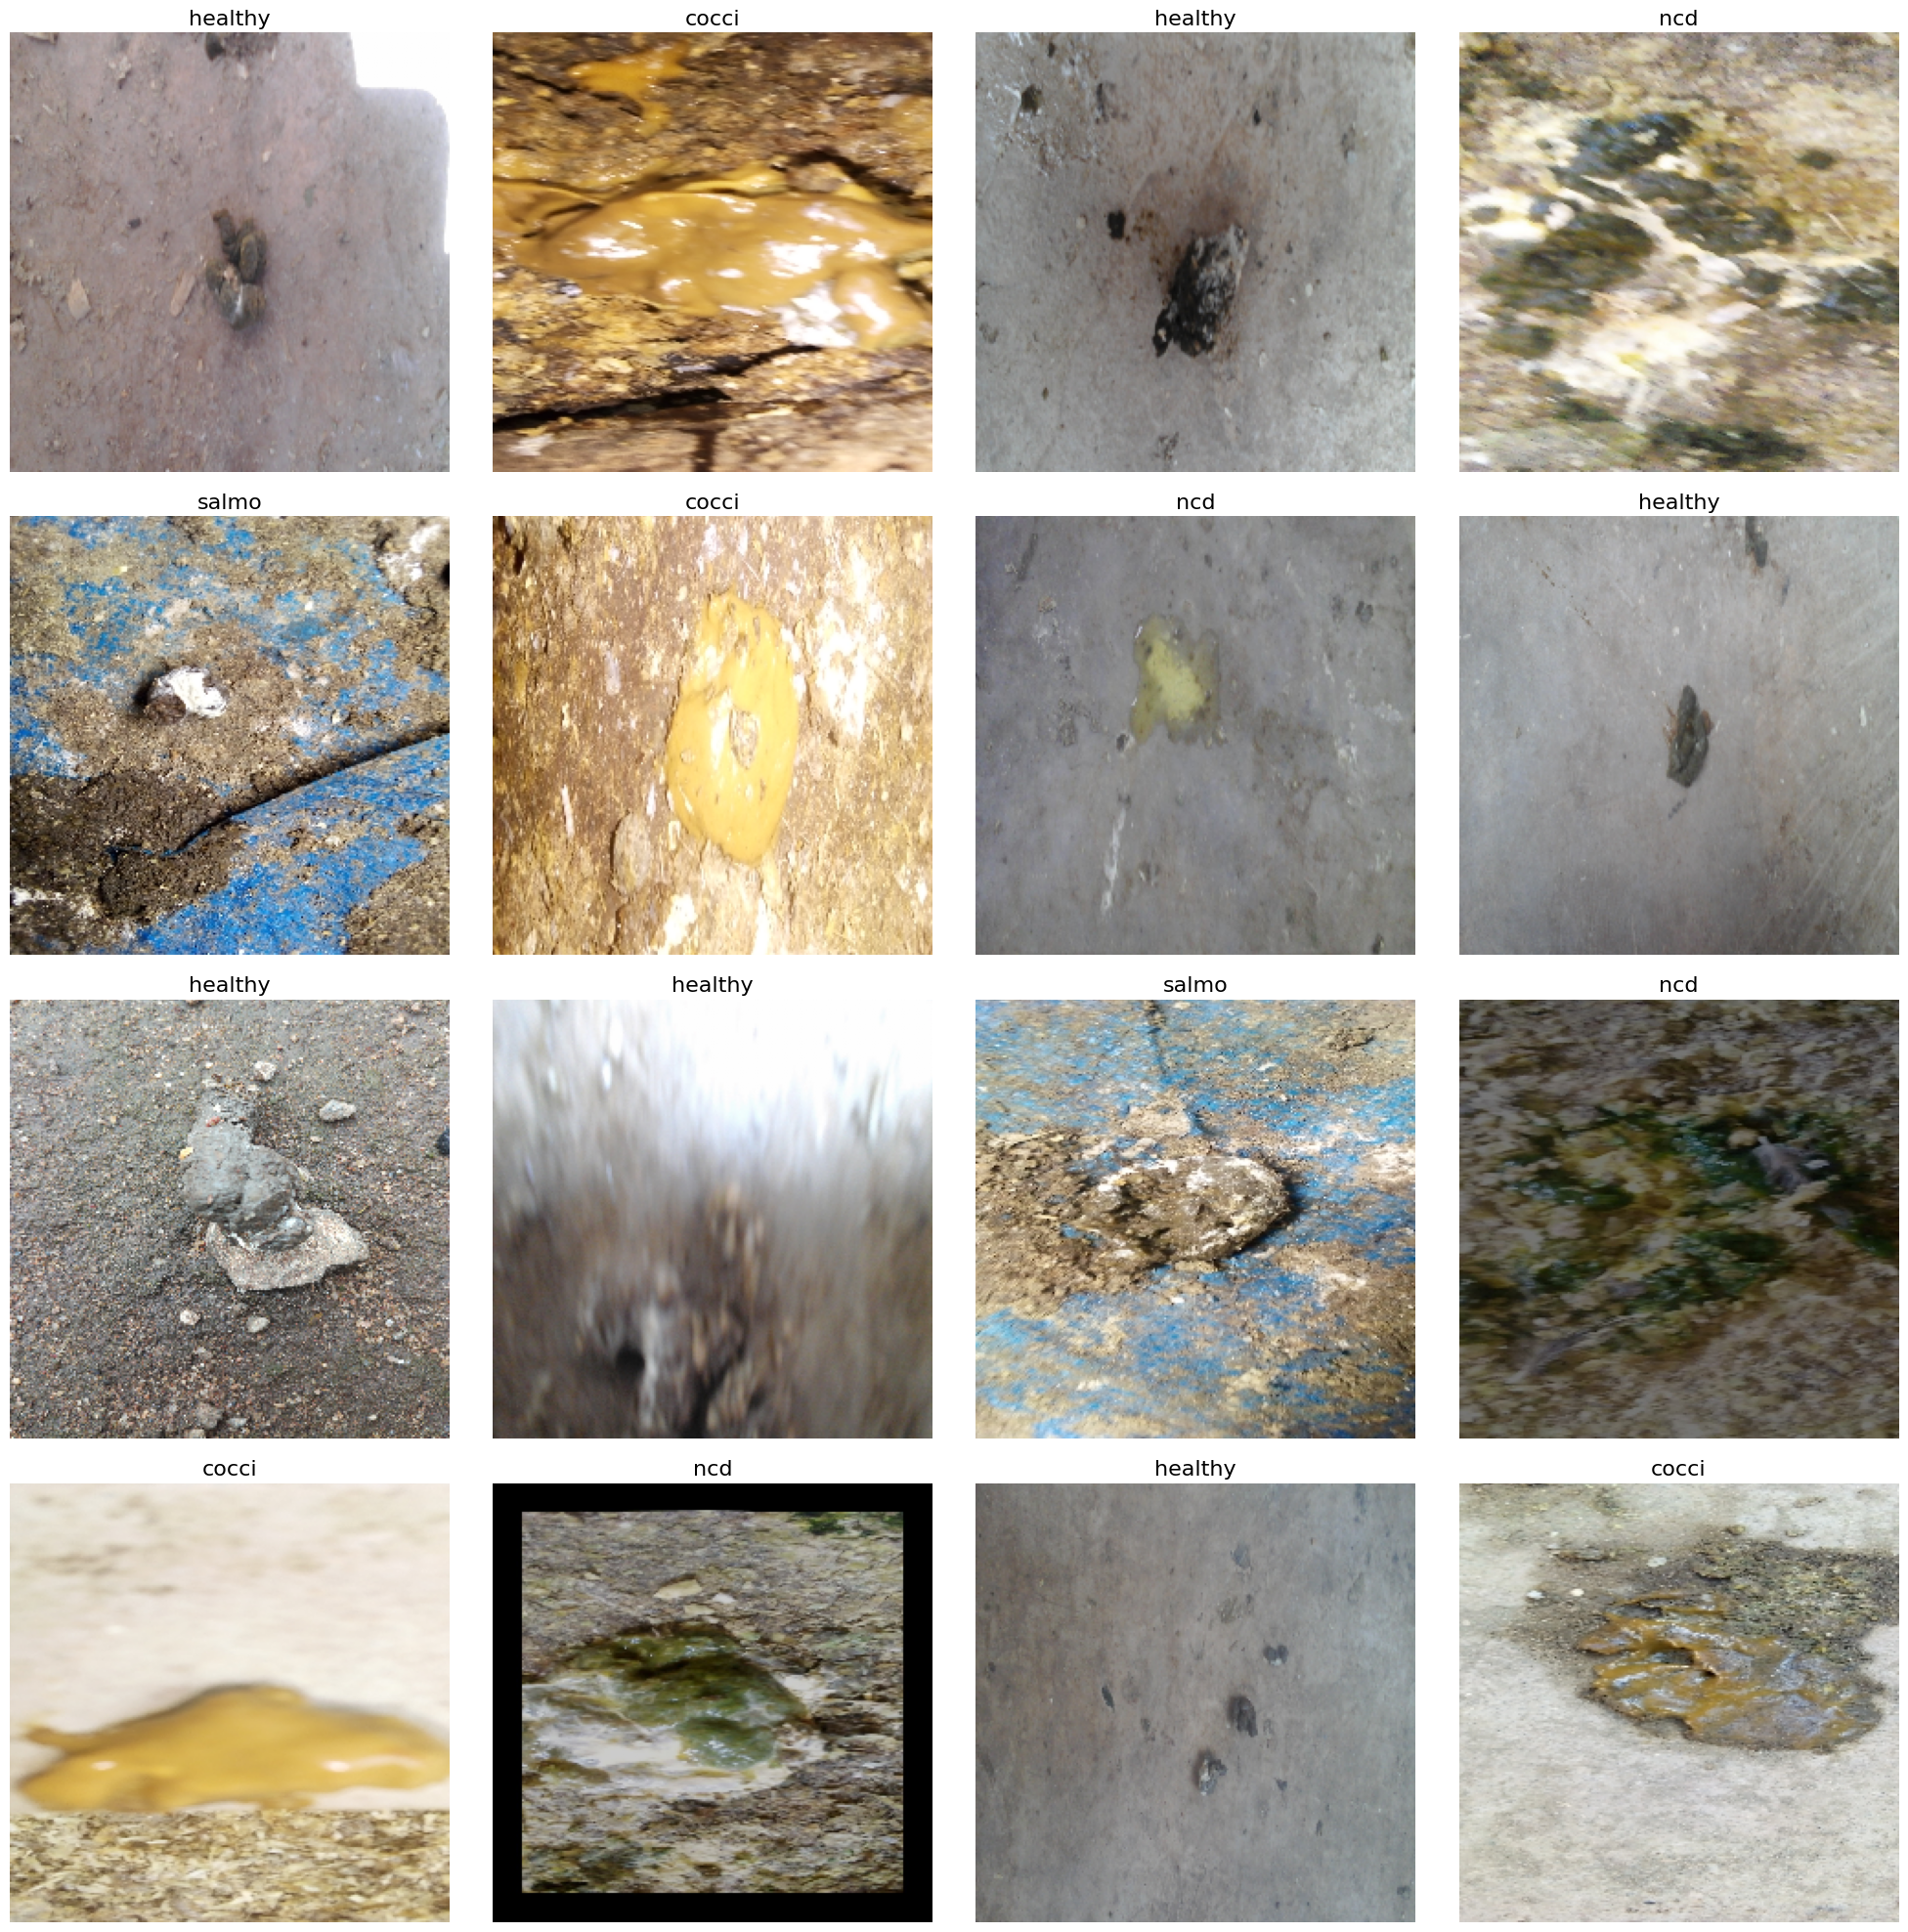

In [ ]:
#Plot Processed Scans
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

([<matplotlib.patches.Wedge at 0x7be7880d1f30>,
 [Text(-1.1187437299570697, 0.11847981550349934, 'Training'),
  Text(1.118743735503509, -0.11847976313132515, 'Testing')],
 [Text(-0.6215242944205942, 0.0658221197241663, '80.0%'),
  Text(0.6215242975019494, -0.06582209062851396, '20.0%')])

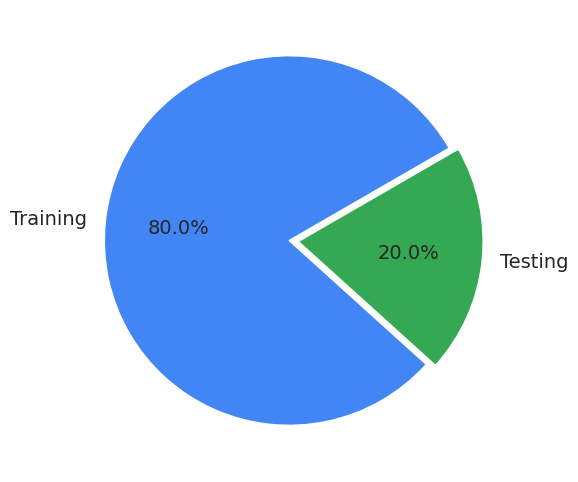

In [ ]:
# Graph Dataset Directories
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(ts_df)],
        labels=['Training', 'Testing'],
        colors=['#4285f4', '#34a853'],
        autopct='%.1f%%',
        explode=(0.025, 0.025),
        startangle=30)

In [ ]:
img_shape= (img_size[0] , img_size[1] , 3)
class_count= len(list(train_gen.class_indices.keys()))
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= 'imagenet',input_shape= img_shape,
                                                              pooling= 'max')
base_model.trainable= False

model= Sequential([
    base_model,
    BatchNormalization(axis= -1,momentum=0.99,epsilon=0.001),
    Dense(256, activation= 'relu'),
    Dropout(rate= 0.2 , seed= 123),
    Dense(class_count, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                       

In [ ]:
checkpoint_path = "./cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

num_epochs= 10
history= model.fit(x= train_gen , validation_data= test_gen, epochs= num_epochs, verbose= 1, validation_steps= None ,
                   shuffle= False,callbacks=[cp_callback])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.8474 
Epoch 1: saving model to ./cp.ckpt
100/100 [==============================] - 2754s 28s/step - loss: 0.4641 - accuracy: 0.8474 - val_loss: 0.2674 - val_accuracy: 0.9050
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9282
Epoch 2: saving model to ./cp.ckpt
100/100 [==============================] - 388s 4s/step - loss: 0.1952 - accuracy: 0.9282 - val_loss: 0.1859 - val_accuracy: 0.9358
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9447
Epoch 3: saving model to ./cp.ckpt
100/100 [==============================] - 393s 4s/step - loss: 0.1596 - accuracy: 0.9447 - val_loss: 0.1635 - val_accuracy: 0.9447
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9575
Epoch 4: saving model to ./cp.ckpt
100/100 [==============================] - 387s 4s/step - loss: 0.1251 - accu

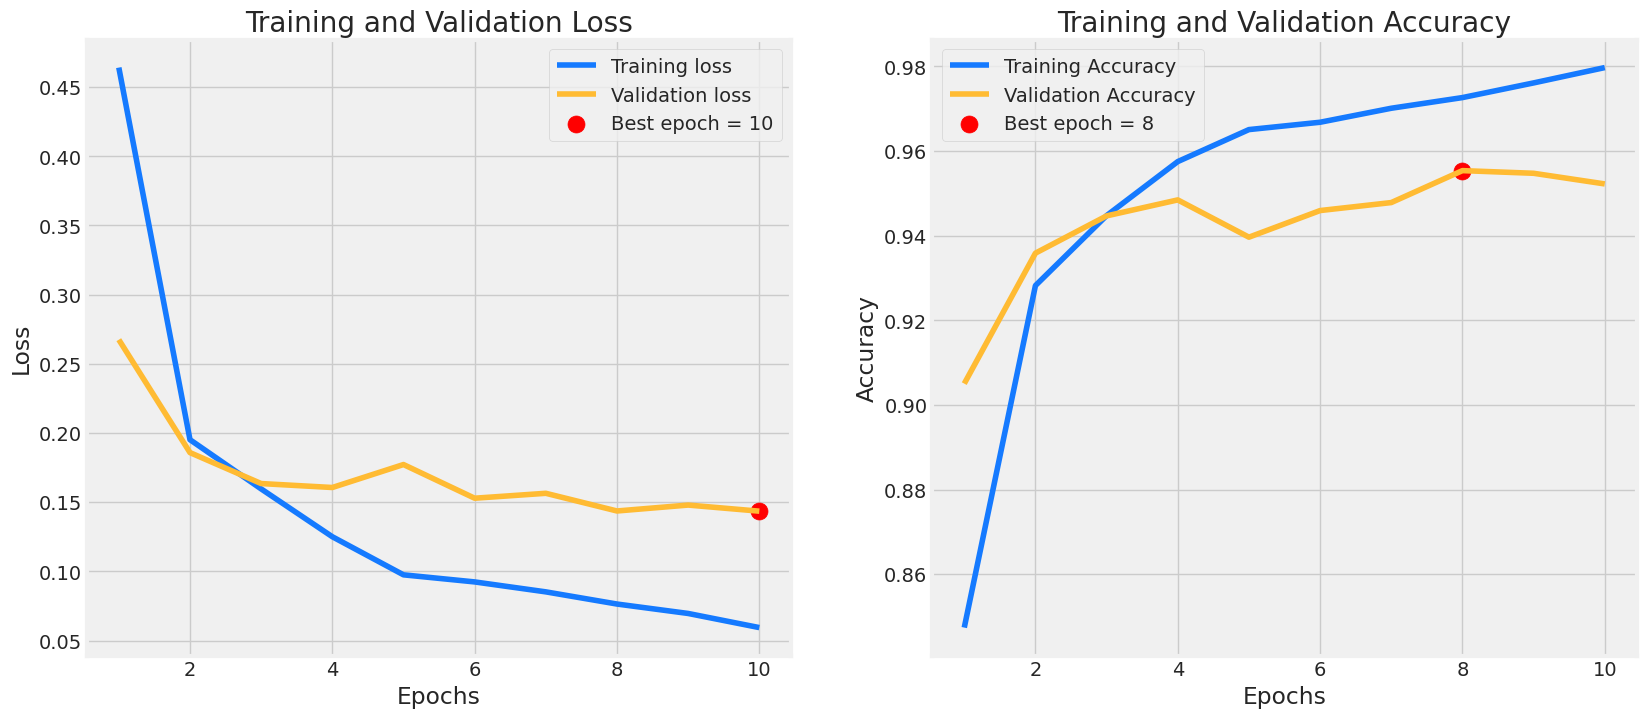

In [ ]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Results for training, validating, testing

# Results for training and testing
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 76s 3s/step - loss: 0.1435 - accuracy: 0.9522
Train Loss:  0.021097680553793907
Train Accuracy:  0.9946456551551819
--------------------
Test Loss:  0.14353038370609283
Test Accuracy:  0.952201247215271


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

25/25 [==============================] - 73s 3s/step


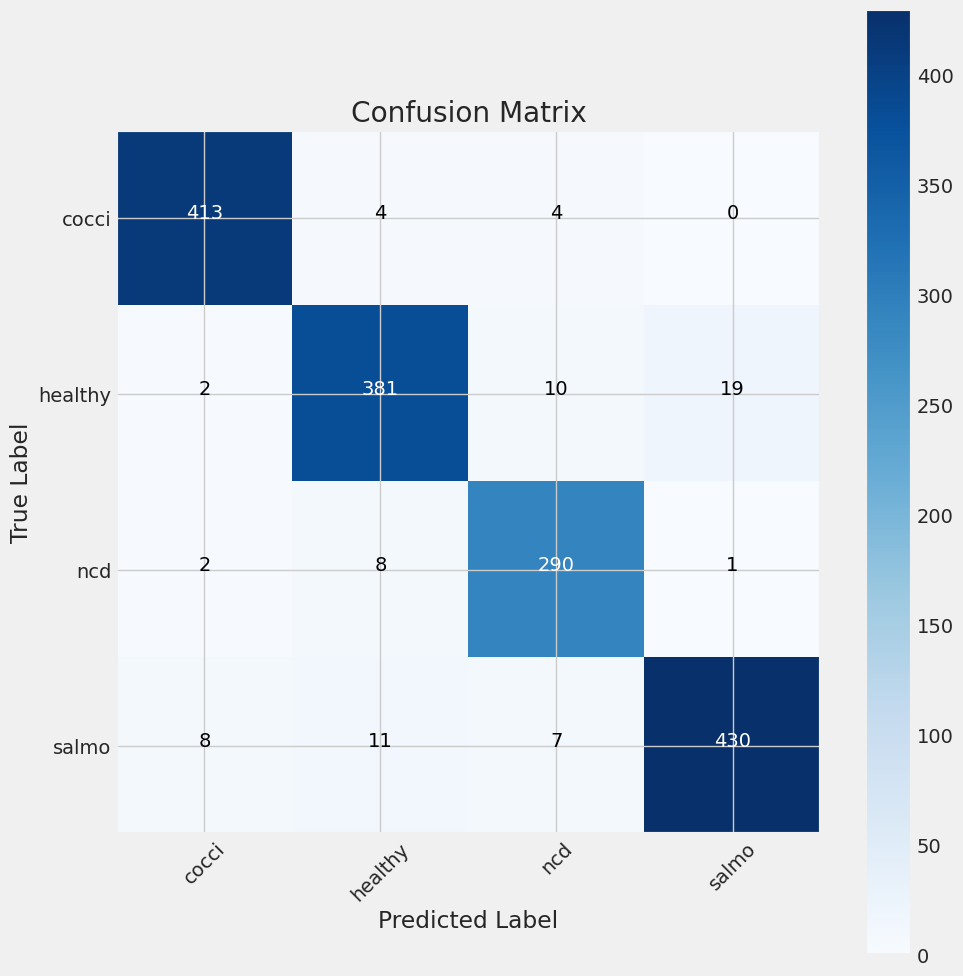

In [ ]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#F1-score
print(classification_report(test_gen.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

       cocci       0.97      0.98      0.98       421
     healthy       0.94      0.92      0.93       412
         ncd       0.93      0.96      0.95       301
       salmo       0.96      0.94      0.95       456

    accuracy                           0.95      1590
   macro avg       0.95      0.95      0.95      1590
weighted avg       0.95      0.95      0.95      1590

